### GJS Output Volume Visualization

In [ ]:
# 6. Plot volume
import numpy as np
import pyvista as pv

pv.set_jupyter_backend("html")

pred_3d = np.load("/home/tommytang111/gap-junction-segmentation/outputs/volumetric_results/unet_h1qrqboc/sem_dauer_2_s000-972/volume_downsampled.npy")
pred_3d_ = np.transpose(pred_3d, (2, 1, 0))
#print(np.unique(pred_3d_, return_counts=True))

# wrap into a pyvista UniformGrid
grid = pv.wrap(pred_3d_)
contour = grid.contour(isosurfaces=[255])

# Volume rendering (interactive)
p = pv.Plotter(notebook=True)
p.add_mesh(contour, color="#02EBFC", show_scalar_bar=False)
p.set_background("black")
p.camera_position = "iso"
p.enable_eye_dome_lighting()        
p.show_axes()                         
#p.export_html("/home/tommytang111/gap-junction-segmentation/html_objects/SEM_Dauer_1_3D.html")
p.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

### Exploring point and isosurface rendering and overlays 

In [2]:
import pyvista as pv
import numpy as np 
from skimage.measure import block_reduce
import os

#Load volumes
#pred = np.load("/home/tommytang111/gap-junction-segmentation/outputs/volumetric_results/unet_u4lqcs5g/sem_adult_s000-699/volume_block_downsampled4x.npy")
points = np.load("/home/tommytang111/gap-junction-segmentation/cs_point_annotations/sem_adult_CSs_block_downsampled8x.npy")
points2 = np.load("/home/tommytang111/gap-junction-segmentation/gj_point_annotations/sem_adult_moved_GJs_downsampled4x.npy")
point_entities = np.load("/home/tommytang111/gap-junction-segmentation/gj_point_annotations/sem_adult_GJs_entities_downsampled8x.npy")

#Block reduce
# pred_ = block_reduce(pred, block_size=(1,4,4), func=np.max)
points_ = block_reduce(points, block_size=(1,2,2), func=np.max)
points2_ = block_reduce(points2, block_size=(1,4,4), func=np.max)
point_entities_ = block_reduce(point_entities, block_size=(1,2,2), func=np.max)

#Experimenting with overlaying objects
# print(pred_.shape)
print(points_.shape)
print(points2_.shape)
print(point_entities_.shape)
#smaller_pred_3d = pred_3d[:200, 256:768, 256:768]
# print(np.unique(pred_3d, return_counts=True))
# print(np.unique(smaller_pred_3d, return_counts=True))

#Convert to list of points
points_list = np.argwhere(points_ == 255)
points_list2 = np.argwhere(points2_ == 255)

#Transform pred into isosurface
# grid = pv.wrap(pred_)
# contour = grid.contour(isosurfaces=[255])

#Transform point_entities into isosurface
grid2 = pv.wrap(point_entities_)
contour2 = grid2.contour(isosurfaces=[255])

#Transform points into glyphs/spheres
point_cloud = pv.PolyData(points_list)
point_cloud2 = pv.PolyData(points_list2)
lowpoly = pv.Sphere(radius=2.0, theta_resolution=8, phi_resolution=8)  # low triangle count
spheres = point_cloud.glyph(scale=False, geom=lowpoly, orient=False) #pv.Sphere(radius=2)
spheres2 = point_cloud2.glyph(scale=False, geom=lowpoly, orient=False) #pv.Sphere(radius=2)

# #Strip all unused data arrays before export and cast from float64 to float32 - reduces export size
# for m in (contour, contour2):
#     m.clear_data()  # remove point/cell data
#     # cast coordinates to float32
#     m.points = m.points.astype(np.float32, copy=False)
    
#Plotting only combined overlay
pv.set_jupyter_backend('none')
pv.global_theme.background = 'black'
pv.force_float=False

p = pv.Plotter(notebook=False, off_screen=True)
p.open_movie("/mnt/e/Tommy/Movies/sem_adult_cs_and_gjs.mp4", framerate=30)
# p.add_mesh(contour, color="#02EBFC", opacity=0.5, show_scalar_bar=False)
p.add_mesh(contour2, color="#BF35FF", opacity=0.5, show_scalar_bar=False)
p.add_mesh(spheres, color="#FA9017", show_scalar_bar=False, smooth_shading=False)
p.add_mesh(spheres, color="#02EBFC", show_scalar_bar=False, smooth_shading=False)
p.add_text("Chemical and Electrical Synapses", position=(0, 0.5), color="#FFFFFF", font_size=24, shadow=True, font="courier")
p.enable_eye_dome_lighting()
p.show_axes()

# 1. Initialize scene to establish the focal point (center of rotation)
p.camera_position = "iso"
p.show(auto_close=False)

# 2. Generate a stable 360-degree orbit path
# viewup=[0,0,1] forces a turntable rotation around the Z-axis
path = p.generate_orbital_path(n_points=360, shift=0.0, viewup=[0,0,1])

p.open_movie("/mnt/e/Tommy/Movies/sem_adult_cs_and_gjs.mp4", framerate=30)

# 3. Loop through the path points (Run twice for 720 frames/2 rotations)
for _ in range(2): 
    for pos in path.points:
        p.camera.position = pos
        p.reset_camera_clipping_range()  # Keeps the flashing fix
        p.write_frame()

p.close()

#p.export_html("/home/tommytang111/gap-junction-segmentation/html_objects/SEM_Adult_point_entities_overlay_only.html")
#p.show()

# #Plotting multiple subplots
# pv.set_jupyter_backend("html")
# pv.global_theme.background = 'black'
# pv.force_float=False
# p = pv.Plotter(notebook=False, shape=(2, 2))
# #Predictions
# p.subplot(0, 0)
# p.add_mesh(contour, color="#02EBFC", show_scalar_bar=False)
# p.add_title("Predictions", color="white", font_size=26)
# p.enable_eye_dome_lighting()
# #Point Entities
# p.subplot(0, 1)
# p.add_mesh(contour2, color="#BF35FF", show_scalar_bar=False)
# p.add_title("Point Entities", color="white", font_size=26)
# p.enable_eye_dome_lighting()
# #Point + Point Entities Overlay
# p.subplot(1, 0)
# p.add_mesh(spheres, color="#FA9017", show_scalar_bar=False) #IT SEEMS LIKE THERE IS ALWAYS A PROBLEM EVERY TIME I USE MORE THAN 2 SUBPLOTS
# p.add_mesh(contour2, color="#BF35FF", opacity=0.5, show_scalar_bar=False)
# p.add_title("Point + Point Entities", color="white", font_size=26)
# p.enable_eye_dome_lighting()
# #Predictions + Point Entities Overlay
# p.subplot(1, 1)
# p.add_mesh(contour, color="#02EBFC", opacity=0.5, show_scalar_bar=False)
# p.add_mesh(contour2, color="#BF35FF", opacity=0.5, show_scalar_bar=False)
# p.add_title("Predictions + Point Entities", color="white", font_size=26)
# p.enable_eye_dome_lighting()
# #Other plot settings
# # p.set_background("black")
# # p.show_axes()
# # p.enable_eye_dome_lighting()
# p.link_views()

# Check mesh stats before export
#print(f"contour: {contour.n_points} points, {contour.n_cells} cells")
# print(f"contour2: {contour2.n_points} points, {contour2.n_cells} cells")
# print(f"spheres: {spheres.n_points} points, {spheres.n_cells} cells")
# print(f"spheres2: {spheres2.n_points} points, {spheres2.n_cells} cells")

# Export gltf
# gltf_path = "/home/tommytang111/gap-junction-segmentation/html_objects/scene2.gltf"
# p.export_gltf(gltf_path)

# # Create minimal HTML wrapper with model-viewer
# wrapper_path = "/home/tommytang111/gap-junction-segmentation/html_objects/scene.html"
# gltf_rel = "scene.gltf"
# html_wrapper = "\n".join([
# "<!DOCTYPE html><html><head><meta charset='utf-8'><title>Scene</title>",
# "<script type='module' src='https://ajax.googleapis.com/ajax/libs/model-viewer/3.3.0/model-viewer.min.js'></script>",
# "<style>",
# "  html,body{margin:0;height:100%;background:#000;}",
# "  model-viewer{width:100%;height:100%;}",
# "</style></head>",
# "<body>",
# f"<model-viewer src='{gltf_rel}' camera-controls touch-action='pan-y'",
# "  shadow-intensity='0' exposure='1.0' environment-image='neutral'",
# "  ar disable-tap",
# "  style='background-color:#000000'>",
# "</model-viewer>",
# "</body></html>"
# ])
# open(wrapper_path, "w").write(html_wrapper)
# print("Wrote:", wrapper_path)


(700, 688, 1248)
(700, 688, 1248)
(700, 688, 1248)


/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/pyvista/core/utilities/points.py:79: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


In [ ]:
#Plotting only combined overlay
pv.set_jupyter_backend("html")
pv.global_theme.background = 'black'
pv.force_float=False

p = pv.Plotter(notebook=True)
p.add_mesh(contour, color="#02EBFC", opacity=0.5, show_scalar_bar=False)
p.add_mesh(contour2, color="#BF35FF", opacity=0.5, show_scalar_bar=False)
p.add_mesh(spheres, color="#FA9017", show_scalar_bar=False, smooth_shading=False)
p.add_text("Prediction + Point Entity + Points Overlay", position=(0, 0.5), color="#02EBFC", font_size=30)
p.enable_eye_dome_lighting()
p.show_axes()
#p.export_html("/home/tommytang111/gap-junction-segmentation/html_objects/SEM_Adult_point_entities_overlay_only.html")
p.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [1]:
import sys
sys.path.append('/home/tommytang111/gap-junction-segmentation/code/src')
from utils import create_dataset_3d
create_dataset_3d(imgs_dir="/home/tommytang111/gap-junction-segmentation/data/sem_adult_larger/SEM_split/imgs", 
                  output_dir="/home/tommytang111/gap-junction-segmentation/data/972vols_sem_adult/vols")

Creating 3D volumes: 100%|██████████| 456/456 [00:04<00:00, 94.81it/s]


(1, 1, 456, (512, 512))

### Transformation Testing

In [ ]:
import cc3d
import numpy as np
from scipy.ndimage import distance_transform_edt


#Create 10x10 numpy array with random 0s and 255s
np.random.seed(0)
random_array = np.random.choice([0, 255], size=(10, 10), p=[0.7, 0.3]).astype(np.uint8)
filtered_array = cc3d.dust(random_array, threshold=2, connectivity=8, in_place=False)
entity_array, num_entities = cc3d.connected_components(filtered_array, connectivity=8, return_N=True)
print('Original Array:')
print(random_array)
print()
print('Filtered Array:')
print(filtered_array)
print('Entity Array')
print(entity_array)


#Create a point array
np.random.seed(31)
point_array = np.random.choice([0, 1], size=(10, 10), p=[0.95, 0.05]).astype(np.uint8)
print('Point Array:')
print(point_array)


#Convert points to boolean array
points_mask = (point_array > 0)


#Distance transform to distance array using inverse (bitwise NOT) of points mask
dist_to_points = distance_transform_edt(~points_mask)


#Create boolean mask of voxels within 15 units of any point
near_points = dist_to_points <= 2


#Keep only entities that overlap with near_points
#Step 1: Get intersection of near_points and entity voxels (using boolean AND) and keep only those labels
keep_labels = np.unique(entity_array[near_points & (entity_array > 0)])
#Step 2: Filter entity array to keep only labels found in Step 1
filtered_entity_array = np.where(np.isin(entity_array, keep_labels), entity_array, 0)
print(filtered_entity_array)


In [12]:
import cc3d
import numpy as np
from scipy.ndimage import distance_transform_edt


#Create 10x10 numpy array with random 0s and 255s
np.random.seed(2)
random_array = np.random.choice([0, 255], size=(10, 10), p=[0.7, 0.3]).astype(np.uint8)
filtered_array = cc3d.dust(random_array, threshold=2, connectivity=8, in_place=False)
entity_array, num_entities = cc3d.connected_components(filtered_array, connectivity=8, return_N=True)
print('Original Array:')
print(random_array)
print()
print('Filtered Array:')
print(filtered_array)
print('Entity Array')
print(entity_array)

#Create a point array
np.random.seed(31)
point_array = np.random.choice([0, 1], size=(10, 10), p=[0.9, 0.1]).astype(np.uint8)
print('Point Array:')
print(point_array)

#Convert to boolean masks (140GB RAM)
points_bool = (point_array > 0)
preds_bool = (filtered_array > 0)

#Compute distance transform from predicted gap junctions (280GB + 210GB RAM)
distance, nearest_indices = distance_transform_edt(~preds_bool, return_indices=True)
print('Distance Array')
print(np.round(distance, 2))
print('Nearest Indices Array')
print(nearest_indices)

#Transform points from 3D array to a list of points
points_list = np.argwhere(points_bool) #shape: (N_points, 3)
print('Points List')
print(points_list)

#Refine points_list to only include points with distance < 2 voxels to nearest gap junction entity
max_distance = 2
points_list_filtered = points_list[distance[points_list[:,0], points_list[:,1]] < max_distance]
num_points = len(points_list)
num_moved_points = len(points_list_filtered)
print('Distance[Points_List]:')
print(distance[points_list[:,0], points_list[:,1]])
print('Less than max distance:')
print(distance[points_list[:,0], points_list[:,1]] < max_distance)
print('Points List Filtered')
print(points_list_filtered)

#For each point find its nearest predicted gap junction
#nearest_indices has shape (3, D, H, W) with [z, y, x] indices at each voxel
nearest_gap_junctions_list = nearest_indices[:, points_list_filtered[:,0], points_list_filtered[:,1]].T
#nearest_gap_junctions now has shape (N_points, 3)
print('Nearest Gap Junctions List:')
print(nearest_gap_junctions_list)

#Create an array of moved points (70GB RAM)
moved_points = np.zeros_like(point_array, dtype=np.uint8)
moved_points[nearest_gap_junctions_list[:,0], nearest_gap_junctions_list[:,1]] = 255
print('Moved Points Array:')
print(moved_points)

#Report statistics
distances_moved = distance[points_list_filtered[:,0], points_list_filtered[:,1]]
#distances_moved has shape (N, 1)
print(f"Moved {len(points_list_filtered)} points to nearest blobs")
print(f"Mean distance moved: {distances_moved.mean():.2f} voxels")
print(f"Max distance moved: {distances_moved.max():.2f} voxels")
print(f'Number of original points: {num_points}')
print(f'Number of moved points: {num_moved_points}')

Original Array:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 255 255   0 255   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0   0 255]
 [255   0 255   0   0   0   0 255   0 255]
 [  0   0   0 255   0   0   0   0 255 255]
 [255   0 255   0   0   0   0   0 255   0]
 [  0   0   0   0 255 255   0   0 255   0]
 [  0   0   0   0   0   0   0   0 255   0]
 [  0   0 255   0   0   0   0   0   0 255]]

Filtered Array:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 255 255   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0   0 255]
 [  0   0 255   0   0   0   0 255   0 255]
 [  0   0   0 255   0   0   0   0 255 255]
 [  0   0 255   0   0   0   0   0 255   0]
 [  0   0   0   0 255 255   0   0 255   0]
 [  0   0   0   0   0   0   0   0 255   0]
 [  0   0   0   0   0   0   0   0   0 255]]
Entity Array
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 2]


In [ ]:
#Testing NR dilation and entity calculations between predictions and points
import numpy as np
from scipy.ndimage import binary_dilation
import cc3d

a = np.zeros((25, 25), dtype=np.uint8)
a[12:14, 12:14] = 255
a_dilated = binary_dilation(a, iterations=3).astype(np.uint8)
points = np.random.choice([0, 255], size=(25, 25), p=[0.95, 0.05]).astype(np.uint8)
preds = np.random.choice([0, 255], size=(25, 25), p=[0.7, 0.3]).astype(np.uint8)

In [33]:
#Get predictions only in nerve ring
NR_preds = preds & a_dilated
#Transform predictions to entities
NR_preds_entities, max_entities = cc3d.connected_components(NR_preds, connectivity=8, return_N=True)
#Create list of entity labels
entity_list = list(range(max_entities + 1))
#Create list of point coordinates
points_list = np.argwhere(points == 255)

#Get entity labels at point locations
entity_labels_at_points = NR_preds_entities[points_list[:, 0], points_list[:, 1]]

#TP: Entities that contain at least one point
tp_entities = set(entity_labels_at_points[entity_labels_at_points > 0])
tp = len(tp_entities)

#FP: Entities that don't contain any points
all_entities = set(range(1, max_entities + 1))
fp_entities = all_entities - tp_entities
fp = len(fp_entities)

#FN: Points that don't fall within any entity (in background)
fn = np.sum(entity_labels_at_points == 0)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"TP (entities with points): {tp}")
print(f"FP (entities without points): {fp}")
print(f"FN (points not in any entity): {fn}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


TP (entities with points): 1
FP (entities without points): 2
FN (points not in any entity): 40
Precision: 0.333, Recall: 0.024, F1: 0.045


In [32]:
NR_preds_entities

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
np.set_printoptions(linewidth=200, threshold=10000)
print("Dilated:")
print(a_dilated)
print("Points:")
print(points)
print("Preds:")
print(preds)
print("NR_preds:")
print(NR_preds)
print('Entity labels at points:')
print(entity_labels_at_points)


Dilated:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Prediction vs EM Comparisons

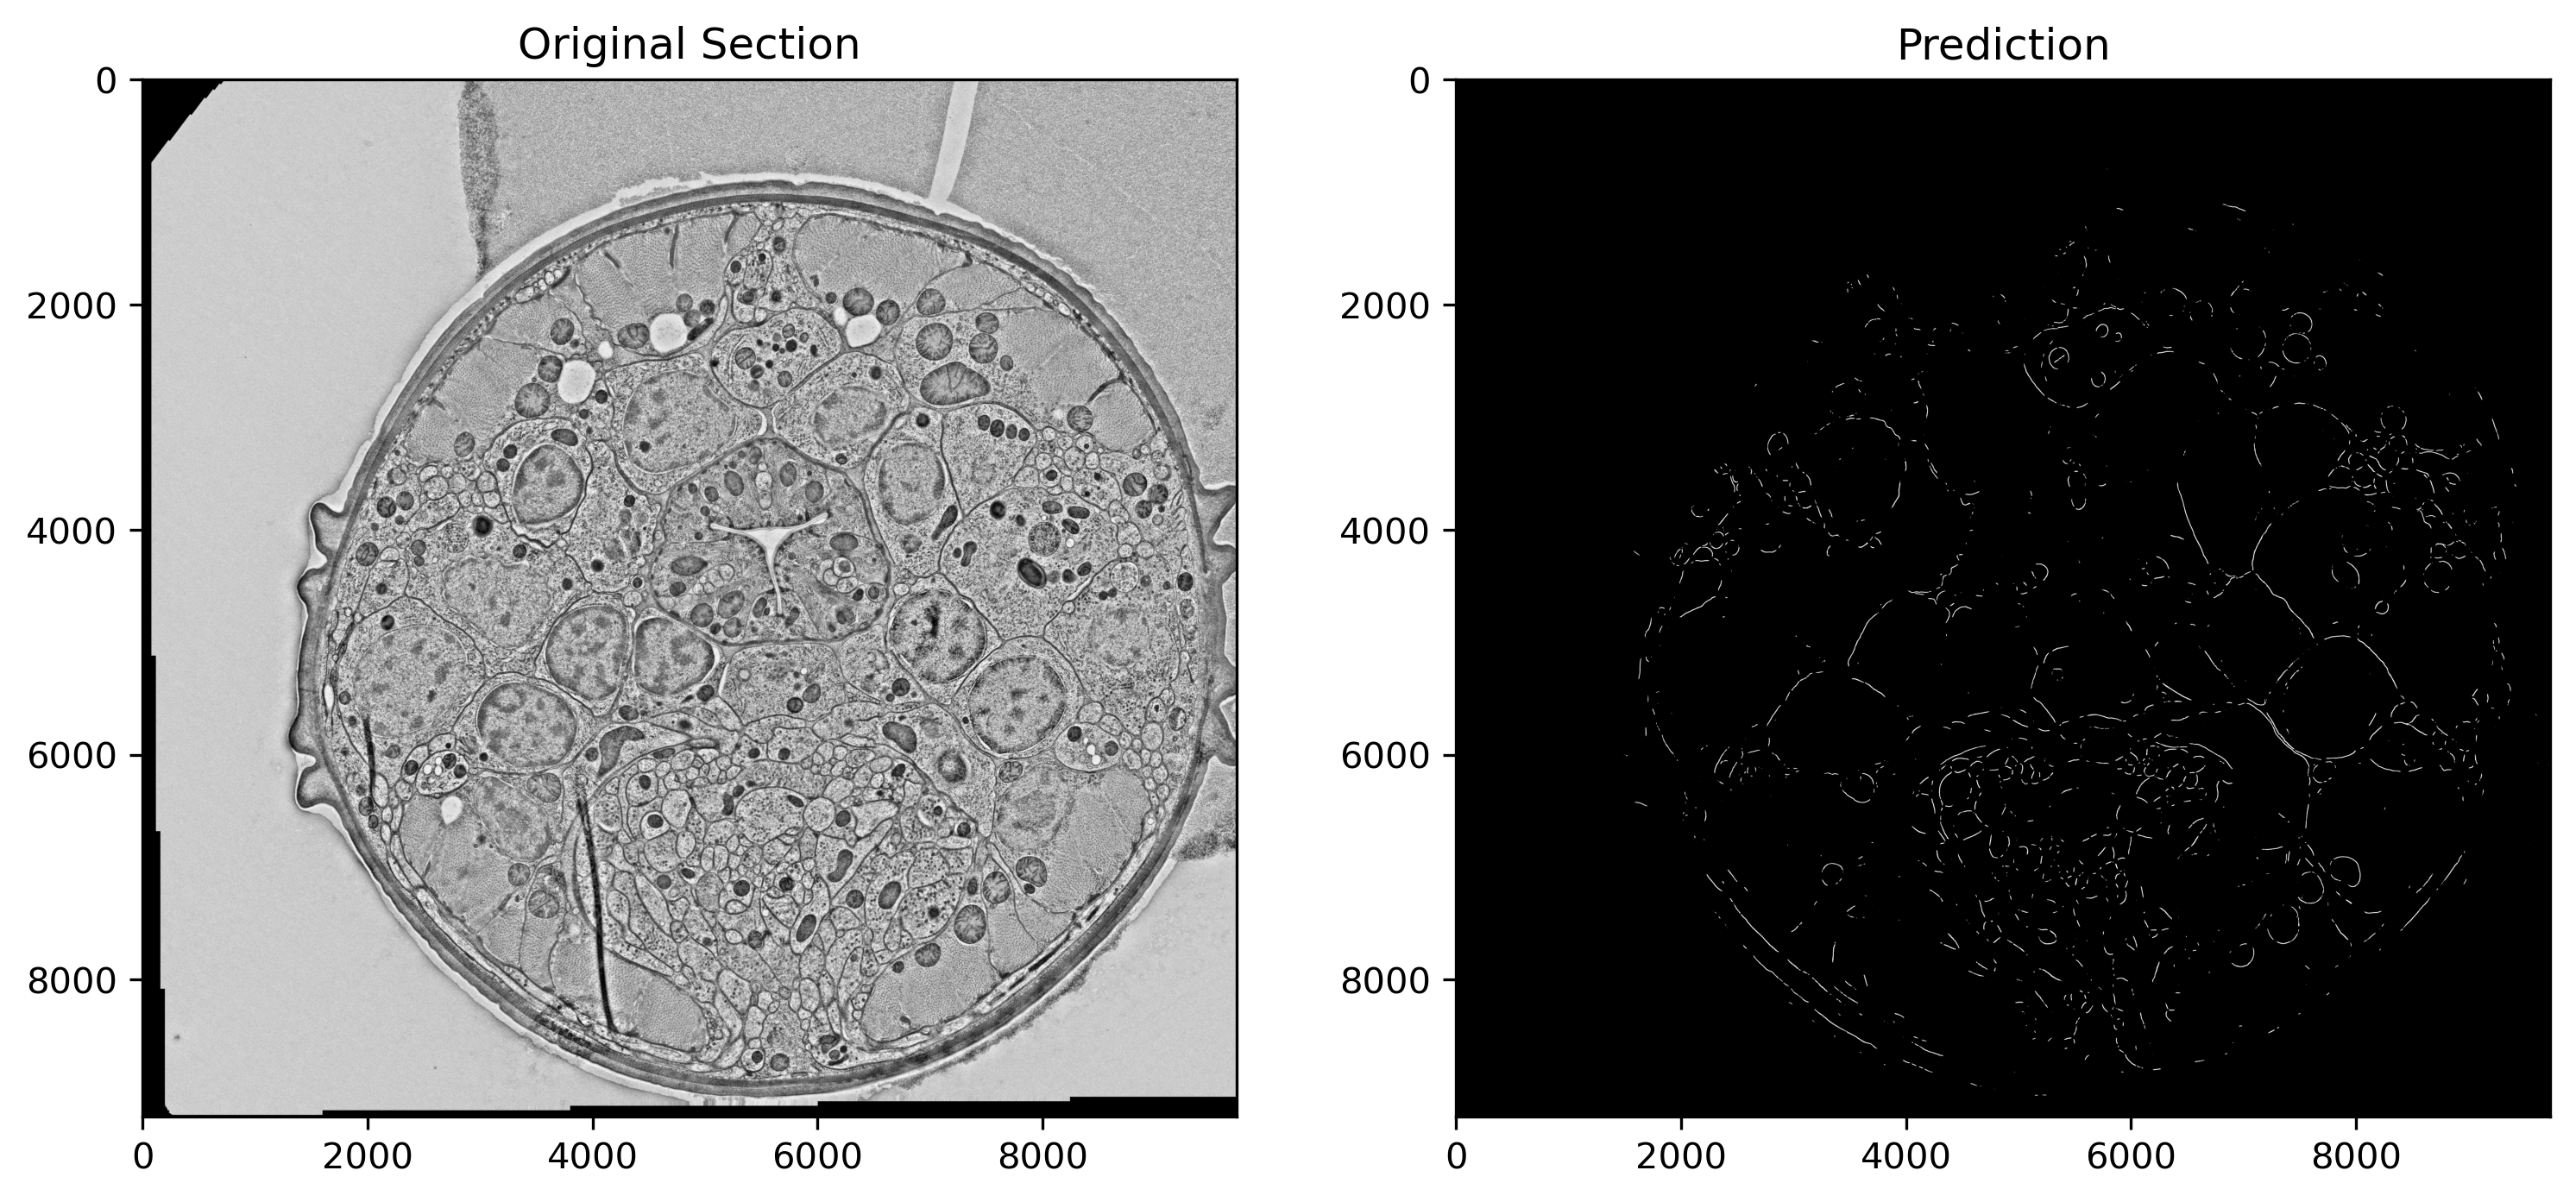

In [68]:
import matplotlib.pyplot as plt
import cv2

section_path = "/mnt/e/Tommy/SEM_dauer_1/Sections/SEM_dauer_1_export_s250.png"
prediction_path = "/mnt/e/Tommy/SEM_dauer_1/Predictions/3D/SEM_dauer_1_export_s250_pred.png"

section = cv2.imread(section_path, cv2.IMREAD_GRAYSCALE)
prediction = cv2.imread(prediction_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 6), dpi=300)
plt.subplot(121)
plt.title("Original Section")
plt.imshow(section, cmap='gray')
plt.subplot(122)
plt.title("Prediction")
plt.imshow(prediction, cmap='gray')
plt.show()

In [ ]:
pred2 = cv2.cvtColor(prediction, cv2.COLOR_GRAY2BGR)
pred2[prediction == 255] = [0, 60, 255] #Blue
pred_overlay = cv2.addWeighted(cv2.cvtColor(section, cv2.COLOR_GRAY2BGR), 1, pred2, 1, 0)
plt.figure(dpi=1000)
plt.imshow(pred_overlay)
plt.title("Overlay")
plt.axis('off')
plt.show()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = cv2.imread("/mnt/e/Tommy/SEM_adult_larger/Neurons/SEM_adult_image_export_s500.png", cv2.IMREAD_UNCHANGED)
#plt.imshow(img, cmap='gray', vmax=50)
print(np.unique(img, return_counts=True))

(array([  0,   1,   2,   4,   7,  10,  11,  12,  13,  15,  16,  17,  23,
        25,  26,  27,  29,  30,  32,  35,  37,  39,  41,  47,  49,  50,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  64,  65,  68,
        69,  70,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  86,  87,  89,  91,  92,  93,  95,  96,  97,  98,  99, 101,
       102, 106, 107, 108, 109, 110, 114, 116, 118, 120, 122, 123, 124,
       127, 128, 129, 131, 133, 135, 139, 140, 142, 144, 146, 147, 150,
       151, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 166,
       167, 168, 170, 171, 174, 177, 178, 179, 182, 183, 185, 186, 187,
       189, 190, 191, 192, 196, 198, 199, 200, 202, 203, 204, 205, 206,
       208, 209, 212, 213, 214, 215, 216, 217, 230], dtype=uint16), array([214261665,    101712,      1260,     48504,      5376,      2216,
            2576,      5548,     88064,     25092,     51468,     60972,
          113104,     23148,     13892,     26372,      7228,    

### 3D Version of PredictMultipleModels() (Needs to be converted to a function and incorporated into PredictMultipleModels)

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of AlbumentationsX (2.0.13) is available! Your version is 2.0.9. Upgrade using: pip install -U albumentationsx
  check_for_updates()


Shape of augmented image: (512, 512, 1)
Shape of volume before model: torch.Size([1, 1, 9, 512, 512])
Shape of augmented image: (512, 512, 1)
Shape of volume before model: torch.Size([1, 1, 9, 512, 512])


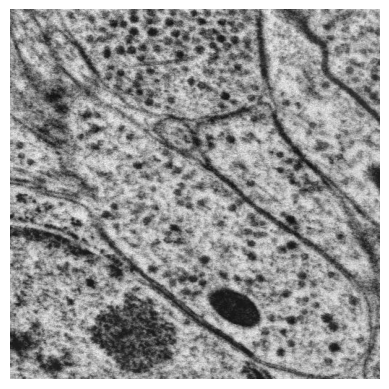

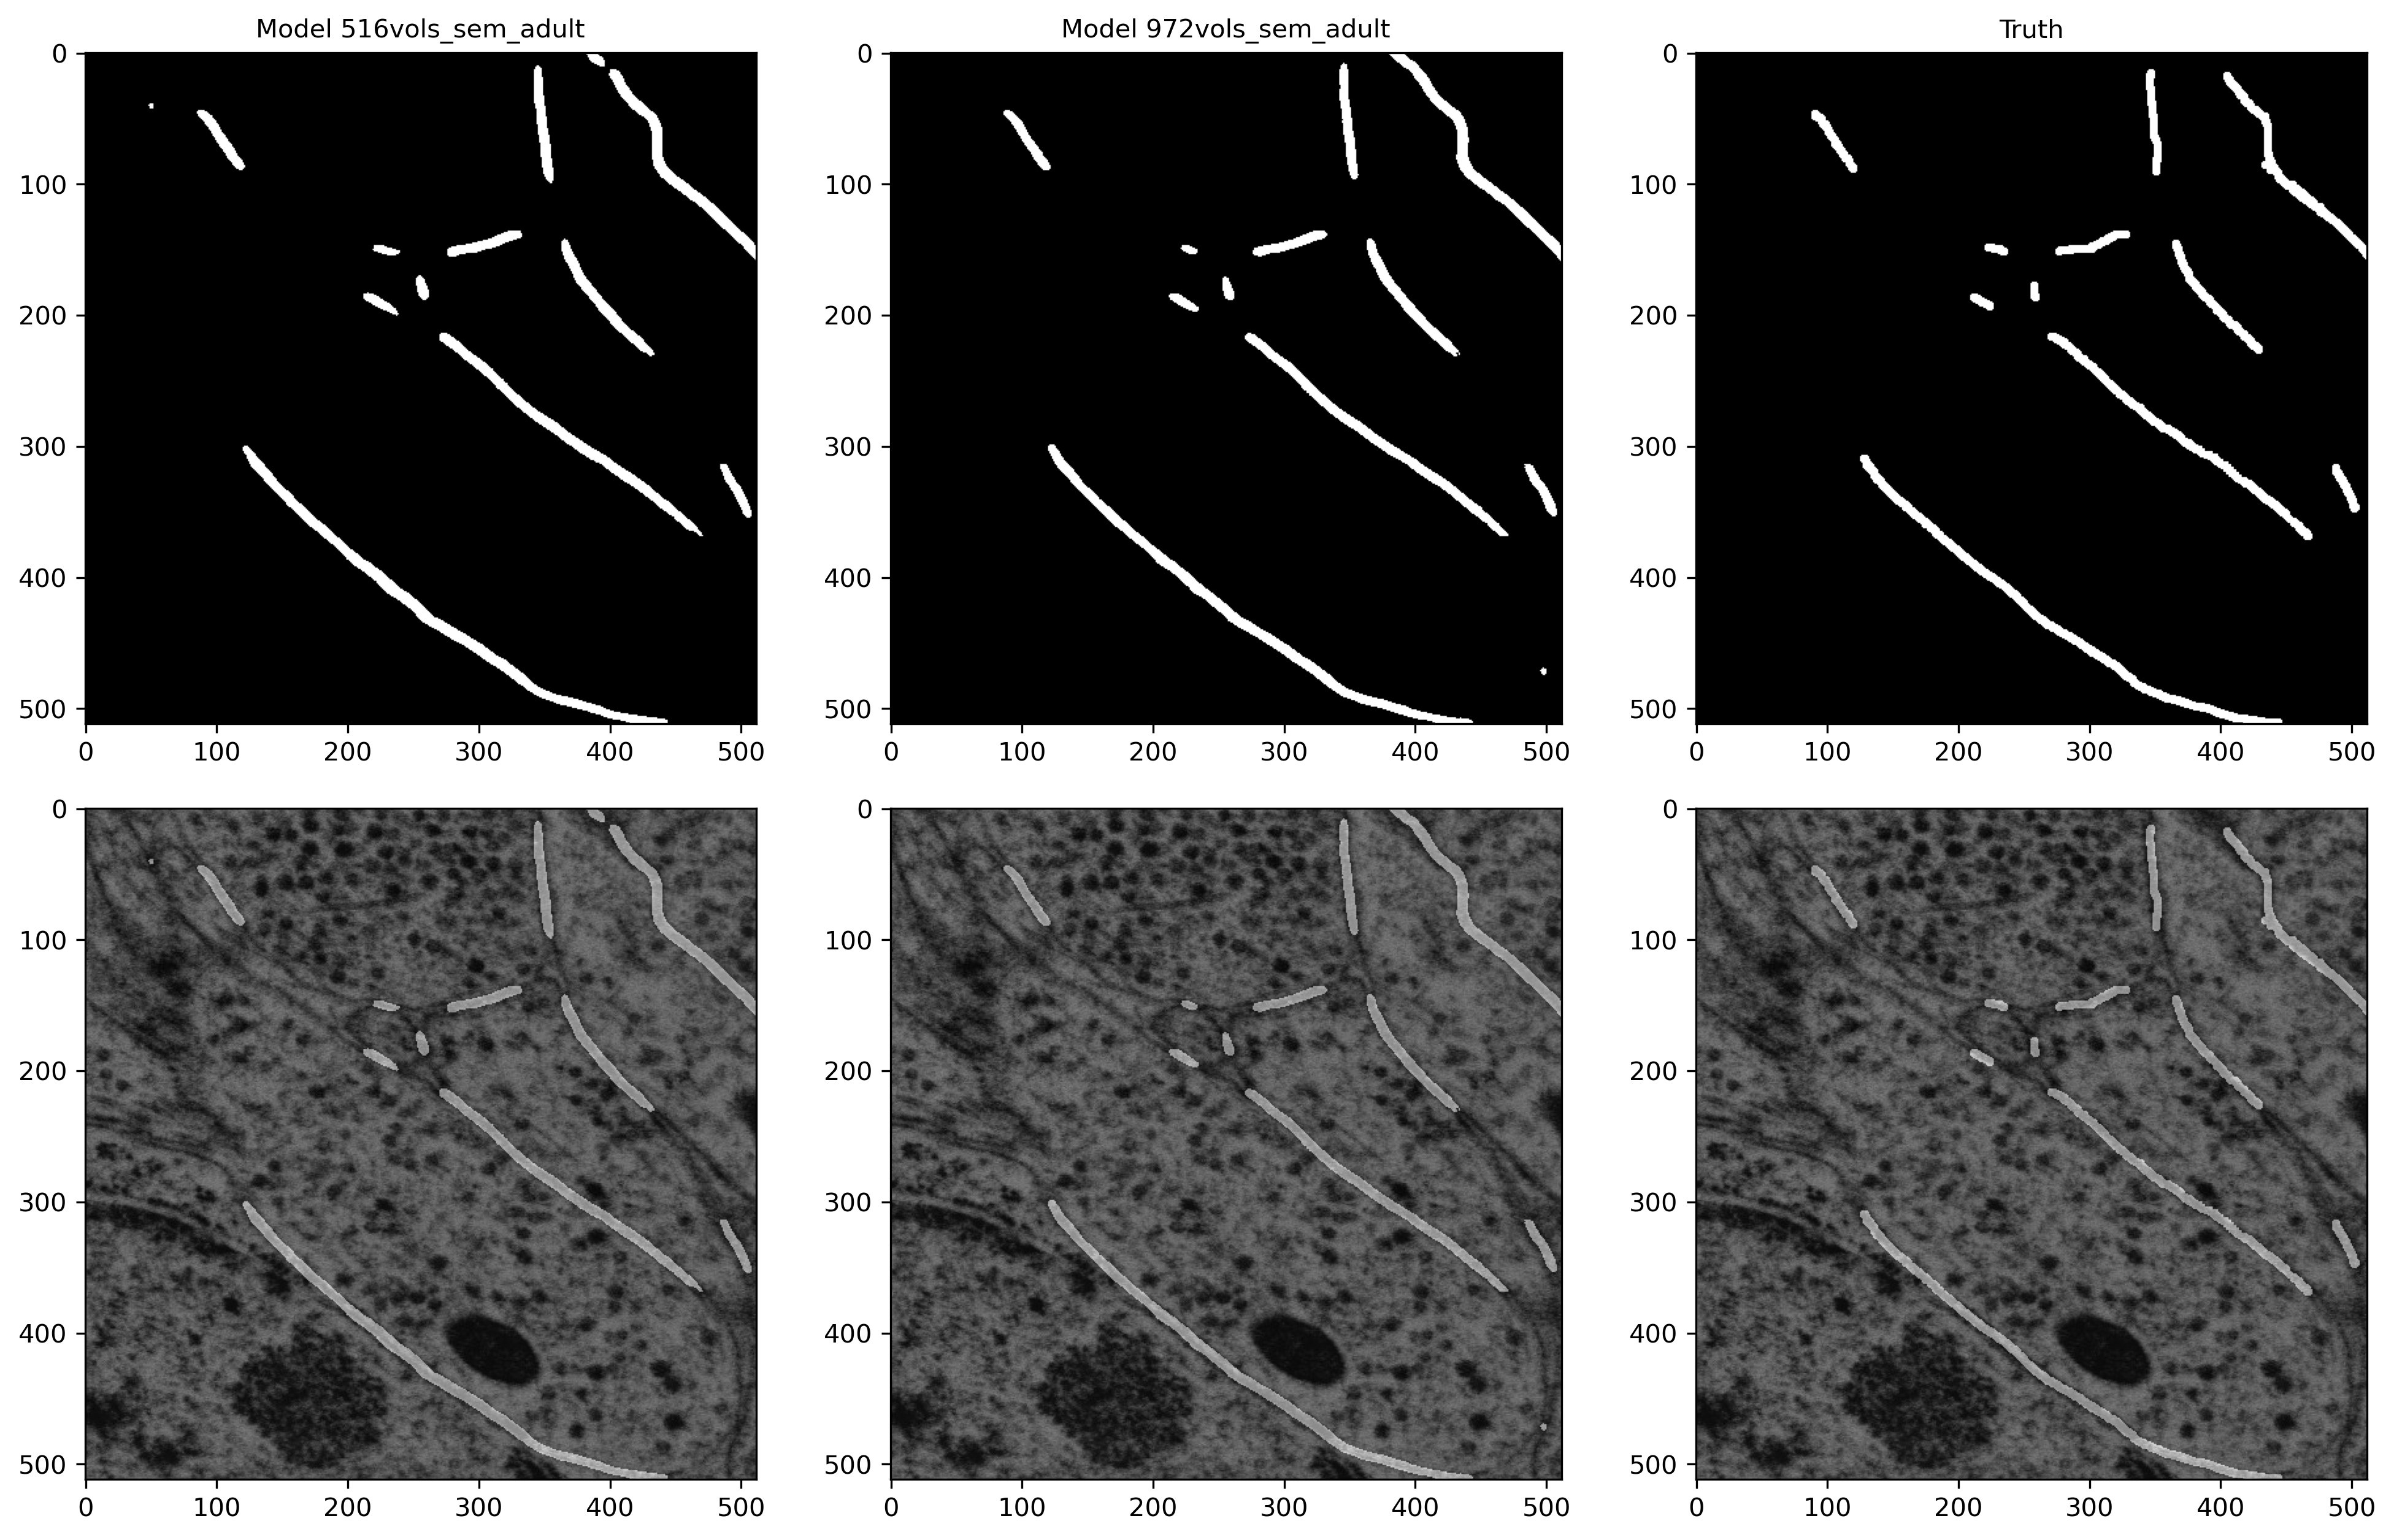

In [1]:
import matplotlib.pyplot as plt
import cv2
import os 
import numpy as np
from pathlib import Path
import sys
sys.path.append('/home/tommytang111/gap-junction-segmentation/code/src')
from utils import single_volume_inference
import random
from models import UNet
import re
import albumentations as A

#Plot two model predictions side by side with ground truth
valid_augmentation3D = A.Compose([A.Normalize(mean=0, std=1)])
data_dir = "/home/tommytang111/gap-junction-segmentation/data/972vols_sem_adult"
vol = os.listdir(Path(data_dir) / "vols")
random_vol = random.choice(vol)
random_vol_path = Path(data_dir) / "vols" / random_vol

vol1 = np.load(random_vol_path)
gts1 = cv2.imread(Path(data_dir) / "gts" / re.sub(r'.npy$', r'_label.png', str(random_vol)), cv2.IMREAD_GRAYSCALE)

model1_pred = single_volume_inference(volume=vol1,
                model_path="/home/tommytang111/gap-junction-segmentation/models/best_models/unet_3D2D_516vols_sem_adult_u4lqcs5g.pt",
                model=UNet(classes=1, three=True),
                augmentation=valid_augmentation3D
                )
                
model2_pred = single_volume_inference(volume=vol1,
                model_path="/home/tommytang111/gap-junction-segmentation/models/newest_models/unet_3D2D_972vols_sem_adult_5dggwboi.pt",
                model=UNet(classes=1, three=True),
                augmentation=valid_augmentation3D)

center_img = vol1[4]
fig1 = plt.figure(1)
plt.imshow(center_img, cmap='gray')
plt.axis('off')

#Plot
fig2 = plt.figure(2, figsize=(16, 12), dpi=300)
plt.subplot(231)
plt.imshow(model1_pred, cmap='gray')
plt.title('Model 516vols_sem_adult', fontsize=10)
plt.subplot(232)
plt.imshow(model2_pred, cmap='gray')
plt.title('Model 972vols_sem_adult', fontsize=10)
plt.subplot(233)
plt.imshow(gts1, cmap='gray')
plt.title('Truth', fontsize=10)
plt.subplot(234)
plt.imshow(center_img, cmap='gray')
plt.imshow(model1_pred, cmap='gray', alpha=0.5)
plt.subplot(235)
plt.imshow(center_img, cmap='gray')
plt.imshow(model2_pred, cmap='gray', alpha=0.5)
plt.subplot(236)
plt.imshow(center_img, cmap='gray')
plt.imshow(gts1, cmap='gray', alpha=0.5)
#plt.tight_layout
plt.subplots_adjust(wspace=0.2, hspace=-0.2)